<a href="https://colab.research.google.com/github/vikas1393/PROJECT/blob/main/Grocery_Inventory_Manager_for_FreshMart_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Grocery_Inventory_and_Sales_Dataset.csv')
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (990, 16)


,Product_ID,Product_Name,Catagory,Supplier_ID,Supplier_Name,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Date_Received,Last_Order_Date,Expiration_Date,Warehouse_Location,Sales_Volume,Inventory_Turnover_Rate,Status
0,29-205-1132,Sushi Rice,Grains & Pulses,38-037-1699,Jaxnation,22,72,70,$4.50,8/16/2024,6/29/2024,9/19/2024,48 Del Sol Trail,32,19,Discontinued
1,40-681-9981,Arabica Coffee,Beverages,54-470-2479,Feedmix,45,77,2,$20.00,11/1/2024,5/29/2024,5/8/2024,36 3rd Place,85,1,Discontinued
2,06-955-3428,Black Rice,Grains & Pulses,54-031-2945,Vinder,30,38,83,$6.00,8/3/2024,6/10/2024,9/22/2024,3296 Walton Court,31,34,Backordered
3,71-594-6552,Long Grain Rice,Grains & Pulses,63-492-7603,Brightbean,12,59,62,$1.50,12/8/2024,2/19/2025,4/17/2024,3 Westerfield Crossing,95,99,Active
4,57-437-1828,Plum,Fruits & Vegetables,54-226-4308,Topicstorm,37,30,74,$4.00,7/3/2024,10/11/2024,10/5/2024,15068 Scoville Court,62,25,Backordered


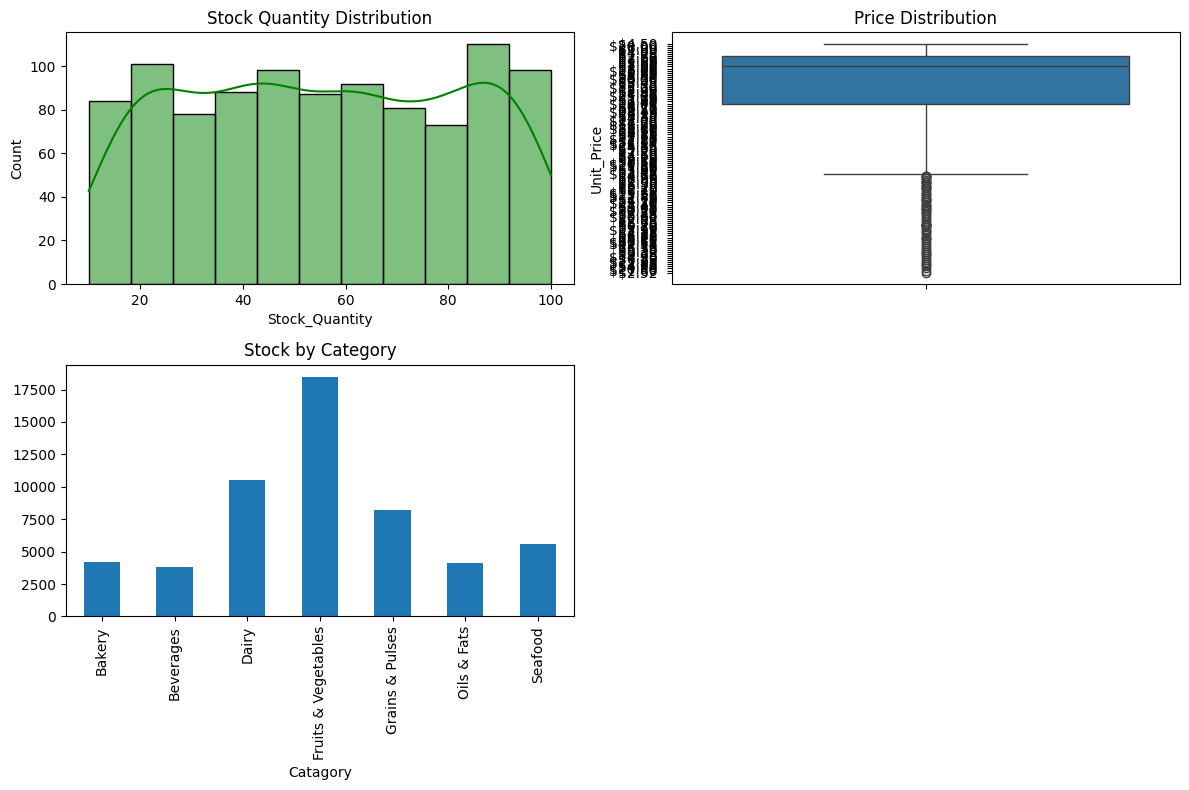


Missing Values:
Product_ID                 0
Product_Name               0
Catagory                   1
Supplier_ID                0
Supplier_Name              0
Stock_Quantity             0
Reorder_Level              0
Reorder_Quantity           0
Unit_Price                 0
Date_Received              0
Last_Order_Date            0
Expiration_Date            0
Warehouse_Location         0
Sales_Volume               0
Inventory_Turnover_Rate    0
Status                     0
dtype: int64


In [3]:
# Basic visualization
plt.figure(figsize=(12,8))

# Stock distribution
plt.subplot(2,2,1)
sns.histplot(df['Stock_Quantity'], kde=True, color='green')
plt.title('Stock Quantity Distribution')

# Price distribution
plt.subplot(2,2,2)
sns.boxplot(y=df['Unit_Price'])
plt.title('Price Distribution')

# Category-wise stock
plt.subplot(2,2,3)
df.groupby('Catagory')['Stock_Quantity'].sum().plot(kind='bar')
plt.title('Stock by Category')

plt.tight_layout()
plt.show()

# Missing values check
print("\nMissing Values:")
print(df.isna().sum())

In [4]:
# Create month and day features from timestamp
df['Last_Order_Date'] = pd.to_datetime(df['Last_Order_Date'])
df['DaysSincePurchase'] = (pd.Timestamp.now() - df['Last_Order_Date']).dt.days

# One-hot encode categoricals
df = pd.get_dummies(df, columns=['Catagory', 'Supplier_Name'])

# Target variable: StockNeeded (MinStock - CurrentStock)
df['StockNeeded'] = df['Reorder_Level'] - df['Stock_Quantity']
df['StockNeeded'] = df['StockNeeded'].apply(lambda x: max(0, x))

print("\nProcessed Features:")
print(df[['DaysSincePurchase', 'StockNeeded']].describe())


Processed Features:
       DaysSincePurchase  StockNeeded
count         990.000000   990.000000
mean          327.193939    14.086869
std           107.026115    20.963315
min           145.000000     0.000000
25%           232.000000     0.000000
50%           332.500000     0.000000
75%           416.000000    24.000000
max           510.000000    85.000000


In [7]:
# Prepare data - drop non-numeric columns that were not one-hot encoded
X = df.drop(['Product_ID', 'Product_Name', 'Stock_Quantity', 'Reorder_Level', 'Last_Order_Date', 'Warehouse_Location', 'Supplier_ID', 'Date_Received', 'Expiration_Date'], axis=1)
y = df['StockNeeded']

# One-hot encode the 'Status' column
X = pd.get_dummies(X, columns=['Status'])

# Convert 'Unit_Price' column to numeric
X['Unit_Price'] = X['Unit_Price'].replace({'\$': ''}, regex=True).astype(float)

# Convert percentage column to numeric
# X['percentage'] = X['percentage'].str.rstrip('%').astype('float') / 100.0


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": XGBRegressor()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    results[name] = mae
    print(f"{name} MAE: {mae:.2f}")

# Feature importance
best_model = RandomForestRegressor().fit(X_train, y_train)
pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

Random Forest MAE: 0.04
XGBoost MAE: 0.09


,feature,importance
362,StockNeeded,0.999838
4,DaysSincePurchase,0.000033
0,Reorder_Quantity,0.000022
2,Sales_Volume,0.000021
1,Unit_Price,0.000017
263,Supplier_Name_Skynoodle,0.000016
3,Inventory_Turnover_Rate,0.000011
8,Catagory_Fruits & Vegetables,0.000005
363,Status_Active,0.000004
364,Status_Backordered,0.000003


In [8]:
# Generate recommendations
df['PredictedNeed'] = best_model.predict(X)

recommendations = df[['Product_ID', 'Product_Name', 'Stock_Quantity', 'Reorder_Level', 'PredictedNeed']].copy()
recommendations['OrderQty'] = recommendations['PredictedNeed'].apply(lambda x: max(0, x))
recommendations['Status'] = np.where(
    recommendations['OrderQty'] > 0,
    "Order Suggested",
    "Stock Adequate"
)

print("\nRecommended Orders:")
display(recommendations[recommendations['Status'] == 'Order Suggested'].sort_values('OrderQty', ascending=False))

# Export recommendations
recommendations.to_csv('replenishment_recommendations.csv', index=False)
print("Recommendations saved to CSV")


Recommended Orders:


,Product_ID,Product_Name,Stock_Quantity,Reorder_Level,PredictedNeed,OrderQty,Status
125,70-149-6756,Heavy Cream,14,99,83.17,83.17,Order Suggested
501,21-013-3508,Cabbage,12,95,80.98,80.98,Order Suggested
345,67-512-9754,Egg (Turkey),19,100,80.87,80.87,Order Suggested
895,57-167-0669,Haddock,19,99,80.72,80.72,Order Suggested
851,79-884-8810,Cucumber,12,93,80.43,80.43,Order Suggested
...,...,...,...,...,...,...,...
906,04-637-8815,Apricot,90,91,1.01,1.01,Order Suggested
617,42-495-7698,Sushi Rice,10,11,1.00,1.00,Order Suggested
696,72-970-0239,Sesame Oil,85,86,1.00,1.00,Order Suggested
379,04-293-6969,Peach,37,38,1.00,1.00,Order Suggested


Recommendations saved to CSV
